# Libraries

In [83]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset
import zipfile
with zipfile.ZipFile('ibm-hr-analytics-attrition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('hr_dataset')

Dataset URL: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
License(s): DbCL-1.0
ibm-hr-analytics-attrition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from tabulate import tabulate

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV

#For Recommendation System
from sklearn.cluster import KMeans
from tqdm import tqdm

#For Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import torch
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier

# Check if a GPU is available
device = 'gpu' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore")

#**FUNCTIONS**

###MODELS

In [85]:
def train_and_evaluate(model, param_grid, x_train, y_train, x_test, y_test):

    color_code = "\033[31m"   # Red
    reset_code = "\033[0m"    # default
    color_yellow = "\033[33m" #Yellow

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(x_train, y_train)


    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)


    train_score = best_model.score(x_train, y_train)
    balanced_test_score = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    print("\n")
    print(f"Best parameters for {color_code}{model.__class__.__name__}{reset_code}: {color_yellow}{grid_search.best_params_}{reset_code}")
    print(f"Best cross-validation accuracy for {color_code}{model.__class__.__name__}{reset_code}: {color_yellow}{grid_search.best_score_:.2f}{reset_code}")
    print(f"Training Accuracy for {color_code}{model.__class__.__name__}{reset_code}: {color_yellow}{train_score:.2f}{reset_code}")
    print(f"Balanced Test Score for {color_code}{model.__class__.__name__}{reset_code}: {color_yellow}{balanced_test_score:.2f}{reset_code}")
    print(f"Test Accuracy for {color_code}{model.__class__.__name__}{reset_code}: {color_yellow}{accuracy:.2f}{reset_code}")
    print(f"Classification Report for {color_code}{model.__class__.__name__}{reset_code}:\n\n{color_yellow}{report}{reset_code}")


#Confusion Matrix
    class_labels = [0, 1]
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 8})
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


#Feature Selection
    if isinstance(best_model, LogisticRegression):
        feat = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.coef_[0]})
        Top_feature = feat.reindex(feat['Importance'].abs().sort_values(ascending=False).index)
    else:
        feat = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
        Top_feature = feat.sort_values(by='Importance', ascending=False)

    Top_feature['Importance'] = Top_feature['Importance'].round(2)
    print('Top 10 Feature selections:')
    print(f"{color_yellow}{Top_feature.head(10)}{reset_code}")

    return



model_params = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, random_state=42),
        {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear', 'saga']}
    ),

    "RandomForest": (
        RandomForestClassifier(random_state=999),
        {'n_estimators': [100, 150], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
    )
}

###Data checking

In [86]:
def datacheck(data):
    print(f"Rows: {data.shape[0]}\nColumns: {data.shape[1]} \n")
    table_data = []

    for i in data.columns:

        top_5_values = data[i].value_counts().nlargest(5).to_dict()
        top_5_str = "\n".join([f"• {k}: {v}" for k, v in top_5_values.items()])
        table_data.append([i, data[i].nunique(), data[i].isna().sum(), data[i].dtypes, top_5_str])

    print(tabulate(table_data, headers=["Column", "Total Unique Values", "Missing Values", "Data Type", "Top 5 Unique Values (Count)"], tablefmt="fancy_grid"))

    return

###Donut Chart

In [87]:
def donut(value,label):

    colr=['#ff9999','#66b3ff','#99ff99','#ffcc99',"cyan", "silver", "red", "orange", "violet"]

    plt.pie(value, explode=(0.1, 0, 0, 0, 0, 0, 0, 0, 0), labels=label,
                    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99',"cyan", "silver", "red","orange", "violet"], autopct='%1.1f%%', startangle=110,shadow=True)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.tight_layout()
    plt.title('Percentage Distribution of Total Employees \n')
    plt.show()

    return

###BAR/ COUNT GRAPH

In [88]:
def visualize_data(a, b, alabel, blabel, chart_type="count"):

    palette = sns.color_palette("husl")


    if chart_type == "count":   #Count Chart
        ax = sns.countplot(x=a, hue=b, palette=palette, alpha=0.5, edgecolor='black', linewidth=0.5)
    elif chart_type == "bar":   #Bar Chart
        ax = sns.barplot(x=a, y=b, palette=palette, alpha=0.5, edgecolor='black', linewidth=0.5)
    else:
        print("Invalid chart type. Choose 'count' or 'bar'.")
        return


    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=7)


    plt.title(f"{alabel} vs {blabel} {chart_type} graph")
    plt.xlabel(alabel)
    plt.ylabel(blabel)
    plt.tick_params(axis='x', labelsize=8, rotation=85)

###Correlation

In [89]:
def Correlaton(x):
  plt.subplots(figsize=(14, 12))
  dfa=x

  sns.heatmap(dfa.corr(), annot=True)
  plt.show()

  return

###ELBOW CURVE

In [90]:
def elbowcurve(x):
  plt.figure(figsize=(5, 4))
  wcss = []

  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=99)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)


  plt.plot(range(1, 11), wcss, marker='o', color='red')
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.tight_layout()
  plt.show()
  return

#**DATASET**

In [124]:
df = pd.read_csv('hr_dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [95]:
datacheck(df)

Rows: 1470
Columns: 35 

╒══════════════════════════╤═══════════════════════╤══════════════════╤═════════════╤══════════════════════════════════╕
│ Column                   │   Total Unique Values │   Missing Values │ Data Type   │ Top 5 Unique Values (Count)      │
╞══════════════════════════╪═══════════════════════╪══════════════════╪═════════════╪══════════════════════════════════╡
│ Age                      │                    43 │                0 │ int64       │ • 35: 78                         │
│                          │                       │                  │             │ • 34: 77                         │
│                          │                       │                  │             │ • 36: 69                         │
│                          │                       │                  │             │ • 31: 69                         │
│                          │                       │                  │             │ • 29: 68                         │
├──────

Removing these columns:  
- BusinessTravel  
- DailyRate  
- DistanceFromHome  
- Education  
- EmployeeCount  
- HourlyRate  
- JobInvolvement  
- MonthlyRate  
- Over18  
- StandardHours  

In [96]:
df=df.drop(columns=["Age","BusinessTravel", "DailyRate", "Gender", "MaritalStatus", "DistanceFromHome", "Education", "EmployeeCount", "HourlyRate", "JobInvolvement", "MonthlyRate", "Over18", "StandardHours"])

#**Graphs**

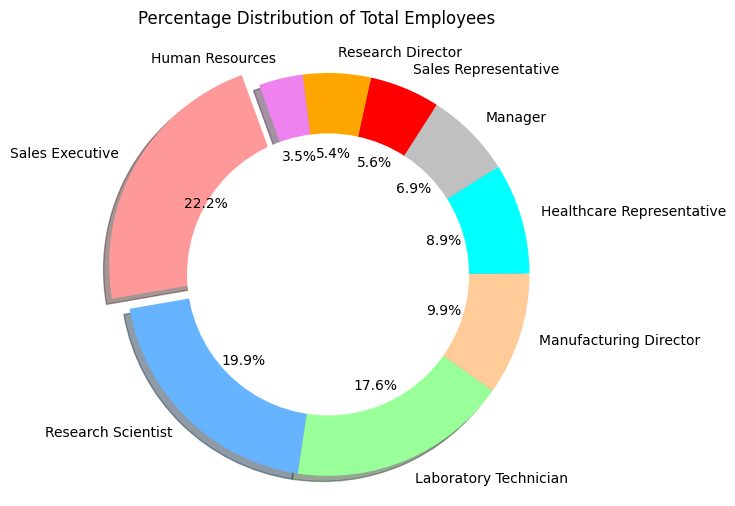

In [97]:
donut(df['JobRole'].value_counts(),df["JobRole"].unique())

In [98]:
jbrole = df.groupby(by='JobRole')['MonthlyIncome'].mean().reset_index()
jbrolemed = df.groupby(by='JobRole')['MonthlyIncome'].median().reset_index()

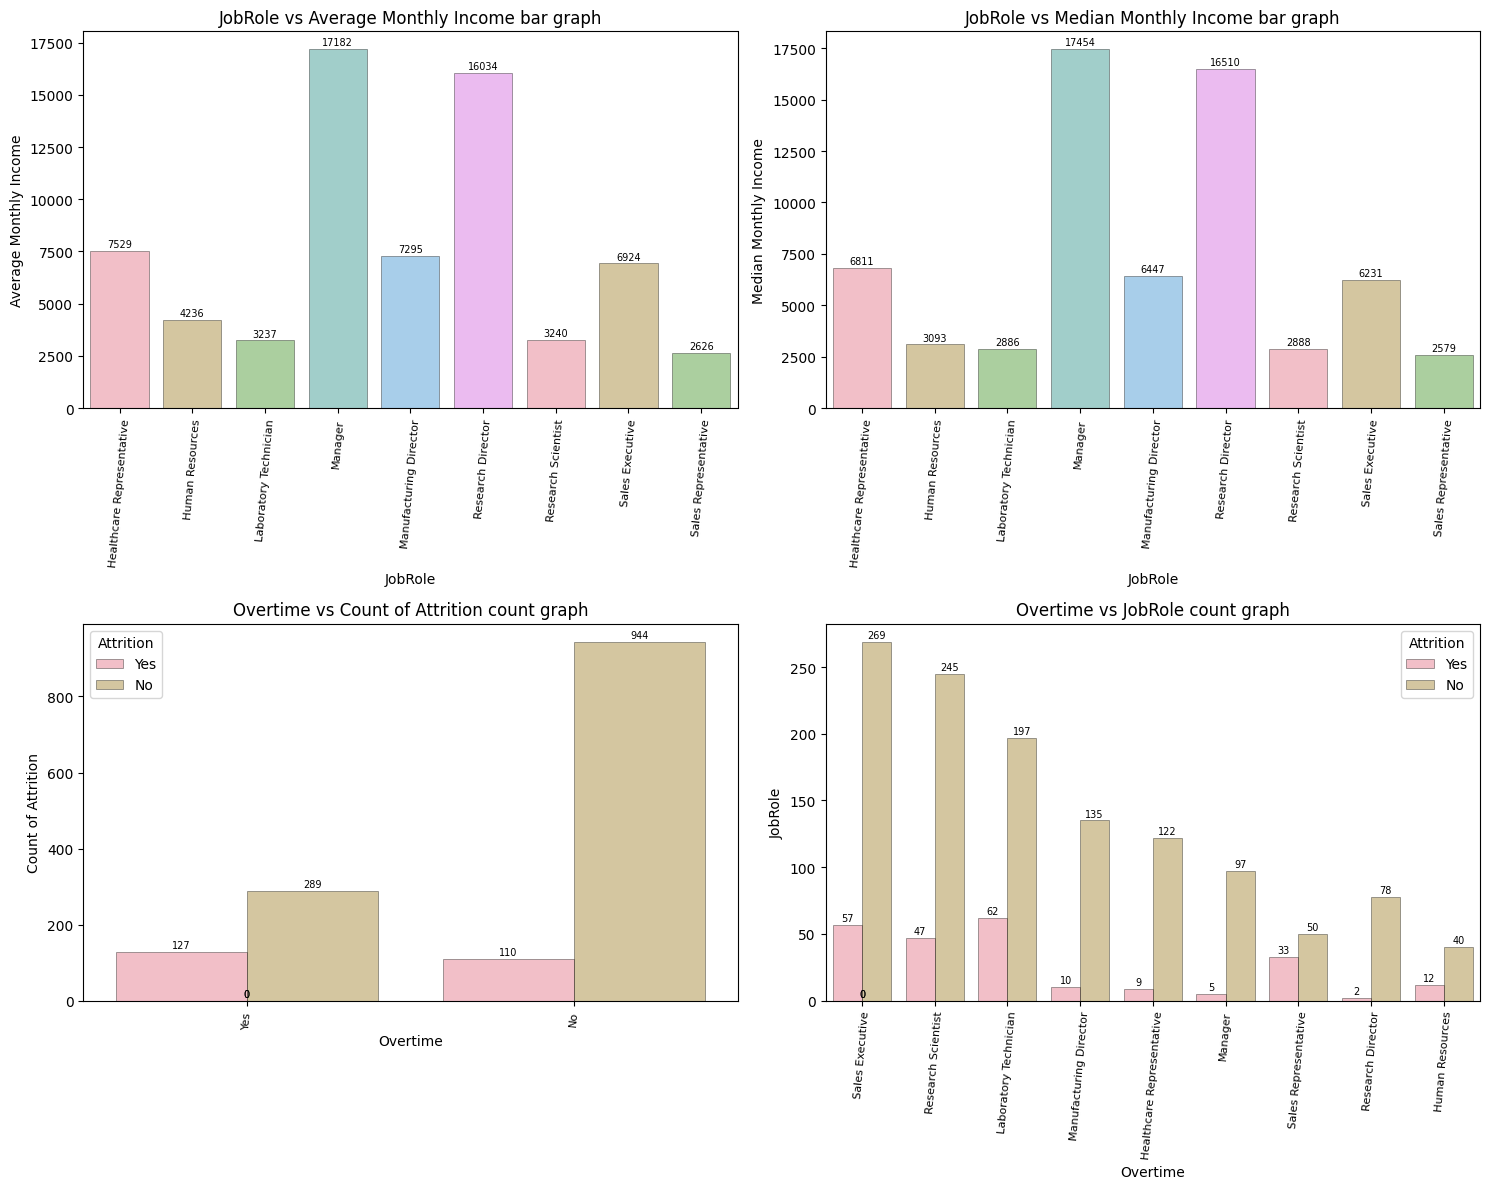

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axes[0, 0])
visualize_data(jbrole['JobRole'],jbrole['MonthlyIncome'],'JobRole','Average Monthly Income', chart_type="bar")

plt.sca(axes[0, 1])
visualize_data(jbrolemed['JobRole'],jbrolemed['MonthlyIncome'],'JobRole','Median Monthly Income', chart_type="bar")

plt.sca(axes[1, 0])
visualize_data(df['OverTime'],df['Attrition'],'Overtime','Count of Attrition', chart_type="count")

plt.sca(axes[1, 1])
visualize_data(df['JobRole'],df['Attrition'],'Overtime','JobRole', chart_type="count")


plt.tight_layout()
plt.show()

In [100]:
df['Attrition'] = df['Attrition'].replace({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].replace({'Yes': 1, 'No': 0})

df["JobRole"].unique()

array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       'Manufacturing Director', 'Healthcare Representative', 'Manager',
       'Sales Representative', 'Research Director', 'Human Resources'],
      dtype=object)

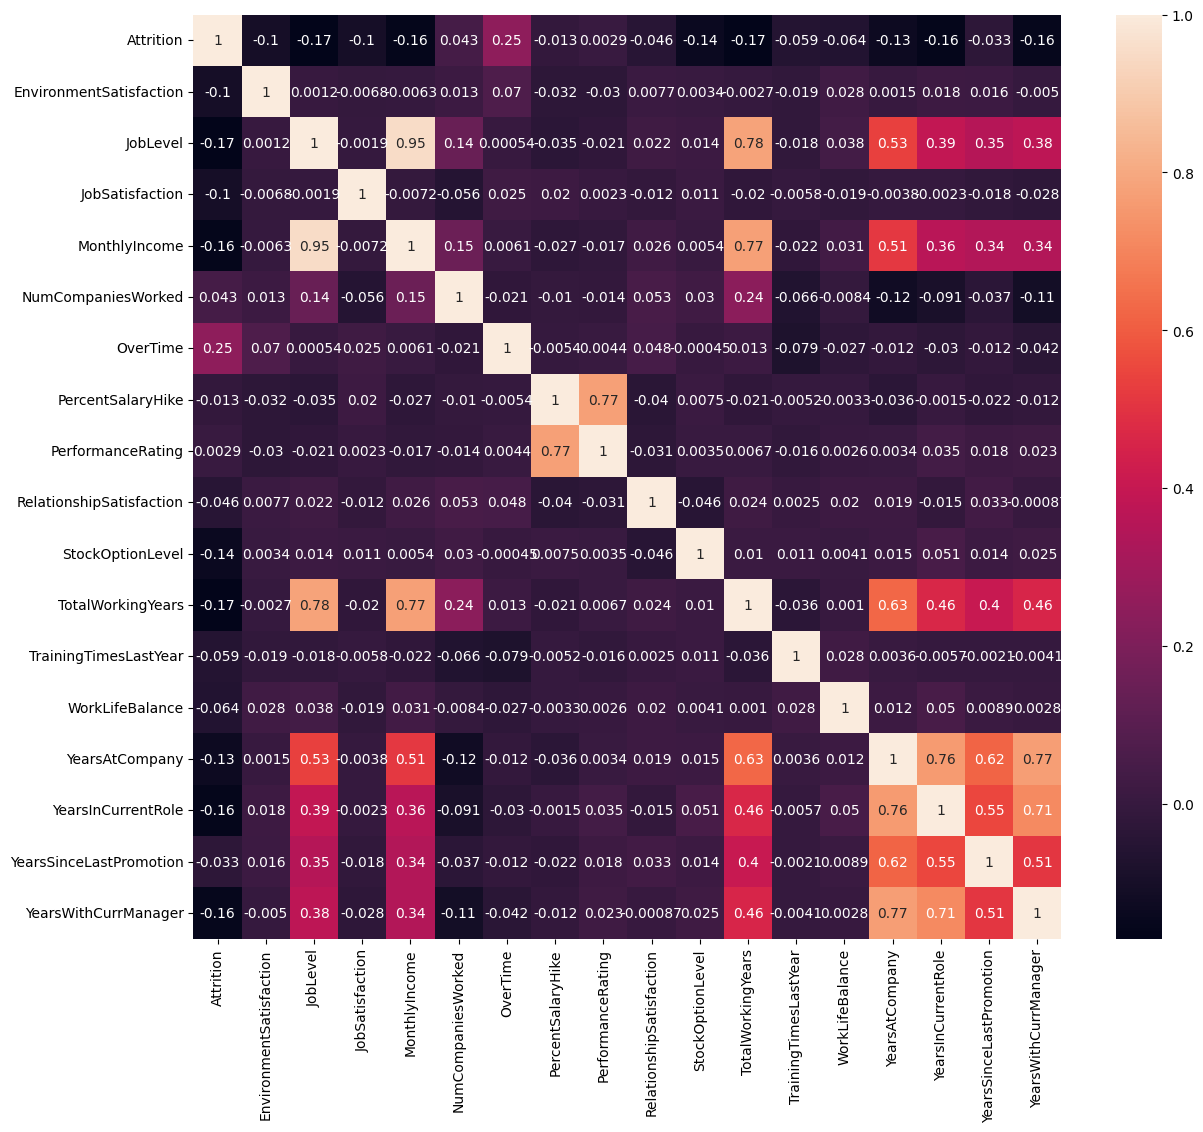

In [101]:
Correlaton(df[['Attrition', 'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']])

**Job Level** and **Monthly Income** got a ***0.87*** point of correlation

For **Attrition**, we got a ***0.25*** point of correlation with **Ovetime**

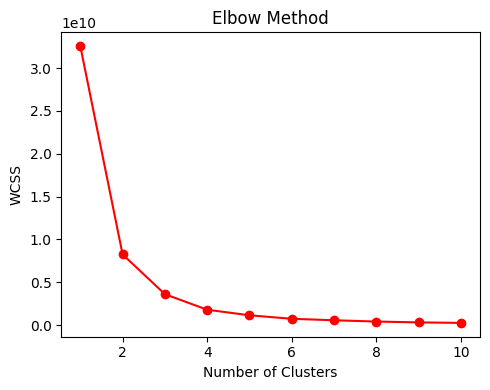

In [102]:
#ELBOW CURVE FOR K MEANS

elbowcurve(df[['Attrition', 'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']])

It seems it's preffered we take k =3

#**DUMMY, SCALING, SPLITING **

Checking the numerical and categorical columns

In [103]:
num_types = [ 'int64', 'float64']
xy = df.select_dtypes(include=num_types)    #Selecting numeric columns
non_numeric_columns = df.select_dtypes(exclude=num_types).columns   #Selecting  categorical columns
non_numeric_columns

Index(['Department', 'EducationField', 'JobRole'], dtype='object')

Dummy for categorical

In [104]:
df_encoded = pd.get_dummies(df,columns=non_numeric_columns, drop_first=True)
df_encoded

,Attrition,EmployeeNumber,EnvironmentSatisfaction,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,1,1,2,2,4,5993,8,1,11,3,1,0,8,0,1,6,4,0,5,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False
1,0,2,3,2,2,5130,1,0,23,4,4,1,10,3,3,10,7,1,7,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,1,4,4,1,3,2090,6,1,15,3,2,0,7,3,3,0,0,0,0,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,0,5,4,1,3,2909,1,1,11,3,3,0,8,3,3,8,7,3,0,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False
4,0,7,1,1,2,3468,9,0,12,3,4,1,6,3,3,2,2,2,2,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,2061,3,2,4,2571,4,0,17,3,3,1,17,3,3,5,2,0,3,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
1466,0,2062,4,3,1,9991,4,0,15,3,1,1,9,5,3,7,7,1,7,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1467,0,2064,2,2,2,6142,1,1,20,4,2,1,6,0,3,6,2,0,3,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1468,0,2065,4,2,2,5390,2,0,14,3,4,0,17,3,2,9,6,0,8,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False


###80:20 Training : Test

In [105]:
X = df_encoded.drop(columns=['Attrition'])
y = df_encoded['Attrition']

x_train, x_test, y_train, y_test = train_test_split(X,y, shuffle=True, stratify=y, test_size=0.2, random_state=99)

###STANDARD SCALER

In [106]:
scaler = StandardScaler()
#For Models
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

#For Recommendation System
xy = scaler.fit_transform(xy)

#MODELS



Training and evaluating LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Best parameters for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy for LogisticRegression: 0.87
Training Accuracy for LogisticRegression: 0.88
Balanced Test Score for LogisticRegression: 0.65
Test Accuracy for LogisticRegression: 0.85
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       247
           1       0.57      0.34      0.43        47

    accuracy                           0.85       294
   macro avg       0.73      0.65      0.67       294
weighted avg       0.83      0.85      0.84       294



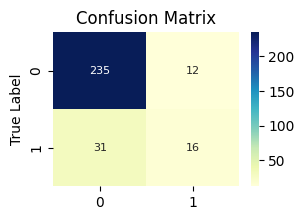

Top 10 Feature selections:
                          Feature  Importance
6                        OverTime        0.89
26  JobRole_Laboratory Technician        0.66
14                 YearsAtCompany        0.65
11              TotalWorkingYears       -0.62
16        YearsSinceLastPromotion        0.62
17           YearsWithCurrManager       -0.54
15             YearsInCurrentRole       -0.49
10               StockOptionLevel       -0.48
19               Department_Sales        0.47
1         EnvironmentSatisfaction       -0.45


Training and evaluating DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}
Best cross-validation accuracy for DecisionTreeClassifier: 0.85
Training Accuracy for DecisionTreeClassifier: 0.89
Balanced Test Score for DecisionTreeClassifier: 0.59
Test Accuracy for DecisionTreeClassifier: 0.84
Classification Report for DecisionTree

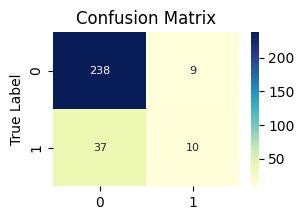

Top 10 Feature selections:
                       Feature  Importance
6                     OverTime        0.19
2                     JobLevel        0.12
4                MonthlyIncome        0.10
1      EnvironmentSatisfaction        0.09
11           TotalWorkingYears        0.08
10            StockOptionLevel        0.07
31     JobRole_Sales Executive        0.06
30  JobRole_Research Scientist        0.06
13             WorkLifeBalance        0.04
12       TrainingTimesLastYear        0.03


Training and evaluating RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for RandomForestClassifier: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy for RandomForestClassifier: 0.86
Training Accuracy for RandomForestClassifier: 0.91
Balanced Test Score for RandomForestClassifier: 0.53
Test Accuracy for RandomForestClassifier: 0.85
Classification Report for RandomForestClassifier:

              precision

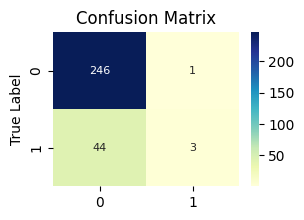

Top 10 Feature selections:
                    Feature  Importance
4             MonthlyIncome        0.11
6                  OverTime        0.10
11        TotalWorkingYears        0.07
0            EmployeeNumber        0.06
14           YearsAtCompany        0.05
10         StockOptionLevel        0.05
17     YearsWithCurrManager        0.05
1   EnvironmentSatisfaction        0.04
5        NumCompaniesWorked        0.04
7         PercentSalaryHike        0.04


Training and evaluating CatBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for CatBoostClassifier: {'depth': 5, 'iterations': 150, 'learning_rate': 0.05}
Best cross-validation accuracy for CatBoostClassifier: 0.88
Training Accuracy for CatBoostClassifier: 0.93
Balanced Test Score for CatBoostClassifier: 0.57
Test Accuracy for CatBoostClassifier: 0.84
Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

           0       0.86      0.97   

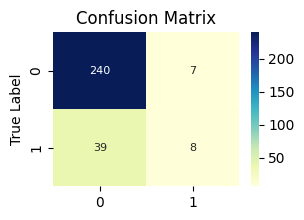

Top 10 Feature selections:
                    Feature  Importance
6                  OverTime       10.98
10         StockOptionLevel        8.07
4             MonthlyIncome        7.55
1   EnvironmentSatisfaction        6.72
11        TotalWorkingYears        6.43
0            EmployeeNumber        5.80
5        NumCompaniesWorked        5.06
3           JobSatisfaction        5.00
17     YearsWithCurrManager        4.43
13          WorkLifeBalance        4.29


Training and evaluating AdaBoost...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Best parameters for AdaBoostClassifier: {'learning_rate': 1.0, 'n_estimators': 50}
Best cross-validation accuracy for AdaBoostClassifier: 0.87
Training Accuracy for AdaBoostClassifier: 0.90
Balanced Test Score for AdaBoostClassifier: 0.64
Test Accuracy for AdaBoostClassifier: 0.85
Classification Report for AdaBoostClassifier:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      

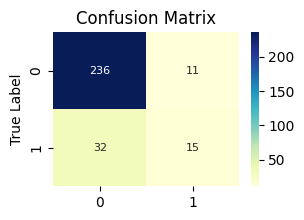

Top 10 Feature selections:
                    Feature  Importance
0            EmployeeNumber        0.12
4             MonthlyIncome        0.10
11        TotalWorkingYears        0.10
13          WorkLifeBalance        0.06
16  YearsSinceLastPromotion        0.06
7         PercentSalaryHike        0.04
1   EnvironmentSatisfaction        0.04
3           JobSatisfaction        0.04
5        NumCompaniesWorked        0.04
12    TrainingTimesLastYear        0.04


Training and evaluating XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation accuracy for XGBClassifier: 0.87
Training Accuracy for XGBClassifier: 0.99
Balanced Test Score for XGBClassifier: 0.57
Test Accuracy for XGBClassifier: 0.83
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       247
        

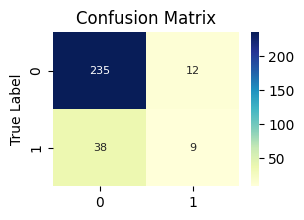

Top 10 Feature selections:
                         Feature  Importance
2                       JobLevel        0.10
6                       OverTime        0.09
31       JobRole_Sales Executive        0.08
10              StockOptionLevel        0.05
19              Department_Sales        0.04
30    JobRole_Research Scientist        0.04
11             TotalWorkingYears        0.03
25       JobRole_Human Resources        0.03
32  JobRole_Sales Representative        0.03
1        EnvironmentSatisfaction        0.03


Training and evaluating GradientBoosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for GradientBoostingClassifier: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
Best cross-validation accuracy for GradientBoostingClassifier: 0.87
Training Accuracy for GradientBoostingClassifier: 1.00
Balanced Test Score for GradientBoostingClassifier: 0.58
Test Accuracy for GradientBoostingClassifier: 0.84
Classification Report for Gra

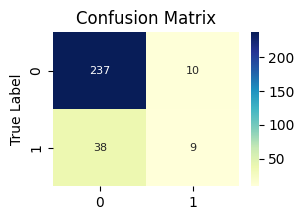

Top 10 Feature selections:
                    Feature  Importance
4             MonthlyIncome        0.15
6                  OverTime        0.09
0            EmployeeNumber        0.08
11        TotalWorkingYears        0.06
10         StockOptionLevel        0.06
1   EnvironmentSatisfaction        0.05
5        NumCompaniesWorked        0.05
3           JobSatisfaction        0.04
17     YearsWithCurrManager        0.04
7         PercentSalaryHike        0.04


Training and evaluating LightGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 190, number of negative: 986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 33
[LightGBM] [Info

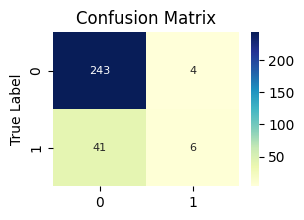

Top 10 Feature selections:
                     Feature  Importance
4              MonthlyIncome          68
1    EnvironmentSatisfaction          52
6                   OverTime          46
10          StockOptionLevel          44
11         TotalWorkingYears          42
5         NumCompaniesWorked          37
0             EmployeeNumber          33
3            JobSatisfaction          33
16   YearsSinceLastPromotion          33
9   RelationshipSatisfaction          32


In [111]:
model_params = {

    "LogisticRegression": (
        LogisticRegression(max_iter=1000, random_state=42),
        {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear', 'saga']}
    ),

    "DecisionTree": (
        DecisionTreeClassifier(random_state=99),
        {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5], 'criterion': ['gini', 'entropy']}
    ),

    "RandomForest": (
        RandomForestClassifier(random_state=999),
        {'n_estimators': [100, 150], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
    ),

    "CatBoost": (
        CatBoostClassifier(task_type="GPU", random_state=42, verbose=0),  # Updated to use GPU
        {'iterations': [100, 150], 'learning_rate': [0.1, 0.05], 'depth': [3, 5, 7]}
    ),

    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {'n_estimators': [50, 100], 'learning_rate': [1.0, 0.1, 0.01]}
    ),

    "XGBoost": (
        XGBClassifier(tree_method='gpu_hist', random_state=42, use_label_encoder=False, eval_metric='mlogloss'),  # Updated to use GPU
        {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5, 7]}
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5, 7]}
    ),

    "LightGBM": (
        LGBMClassifier(device='cpu', random_state=42),  # Updated to use GPU
        {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5, 7]}
    )
}

best_models = {}

color_code = "\033[31m"  # Red
reset_code = "\033[0m"   # default color
bold_code = "\033[1m"    # Bold


for model_name, (model, params) in model_params.items():
    print(f"\n\n{bold_code}Training and evaluating {color_code}{model_name}{reset_code}...")
    best_models[model_name] = train_and_evaluate(model, params, x_train_std, y_train, x_test_std, y_test)

We find Logistic Regression and CatBoost Classifier both performed well and have quite similar values. The second best is AdaBoost

#**RECOMMENDATION SYSTEM**

In [112]:
#CLUSTERS
n_clusters=3   #Taking k =3

km = KMeans(n_clusters)
k=km.fit_predict(xy)
df['no']=k   #New column displaying the clusters created

In [119]:
class Recommend():
    def __init__(self, rec_data):
        self.rec_data_ = rec_data

    def change_data(self, rec_data):
        self.rec_data_ = rec_data

    def get_recomm(self, JobRole, JobLevel, amount=3):
        distances = []

        filtered_data = self.rec_data_[(self.rec_data_.JobRole.str.lower() == JobRole.lower()) &
                                       (self.rec_data_.JobLevel == JobLevel) &
                                       (self.rec_data_.Attrition == 0)]       # Added condition for Attrition = NO


        if filtered_data.empty:
            print(f"No data found for JobRole '{JobRole}' and JobLevel '{JobLevel}' and Department '{Department}'.")
            return pd.DataFrame()
        # Return an empty DataFrame if no data is found

        topone = filtered_data.head(1).values[0]      #topmost recommendation row

        # For the ones that doesn't match with our criteria
        res_data = self.rec_data_[(self.rec_data_.JobRole.str.lower() != JobRole.lower()) |
                                  (self.rec_data_.JobLevel != JobLevel) ]



        for i in tqdm(res_data.values, desc="Calculating distances"):
            dist = 0
            for col in np.arange(len(res_data.columns)):
                if not col in [1, 2,6, 23]:          #indeces of non-numerical columns
                    dist = dist + np.absolute(float(topone[col]) - float(i[col]))     #Manhettan distances by  topmost one and current row
            distances.append(dist)


        res_data['distance'] = distances
        res_data = res_data.sort_values('distance')
        columns = ['Attrition','EmployeeNumber', 'JobRole', 'JobLevel', 'Department']

        top_recommendations = res_data[columns].head(amount)

        return top_recommendations


In [120]:
recommender = Recommend(df)

In [121]:
recommender.get_recomm('Research Scientist',1)

Calculating distances: 100%|██████████| 1236/1236 [00:00<00:00, 17780.83it/s]


,Attrition,EmployeeNumber,JobRole,JobLevel,Department
17,0,22,Laboratory Technician,1,Research & Development
5,0,8,Laboratory Technician,1,Research & Development
102,1,137,Laboratory Technician,1,Research & Development


In [122]:
recommender.get_recomm('Research Director', 5)

Calculating distances: 100%|██████████| 1444/1444 [00:00<00:00, 16424.48it/s]


,Attrition,EmployeeNumber,JobRole,JobLevel,Department
105,0,140,Manager,5,Human Resources
29,0,38,Manager,5,Sales
25,0,32,Manager,5,Research & Development


In [123]:
recommender.get_recomm('Research Scientist', 2)

Calculating distances: 100%|██████████| 1413/1413 [00:00<00:00, 19371.93it/s]


,Attrition,EmployeeNumber,JobRole,JobLevel,Department
80,0,104,Laboratory Technician,2,Research & Development
9,0,13,Healthcare Representative,2,Research & Development
104,0,139,Healthcare Representative,2,Research & Development
